In [67]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

import tarfile
import urllib

#!pip install seaborn
#!pip install yellowbrick
#!pip install bertopic
from bertopic import BERTopic

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import clear_output

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from pandas.api.types import CategoricalDtype
import scipy


https://medium.com/@dennisndungu68/text-classification-using-k-means-33bea24e4a94

https://realpython.com/k-means-clustering-python/#how-to-build-a-k-means-clustering-pipeline-in-python

https://towardsdatascience.com/kmeans-clustering-for-classification-74b992405d0a


In [2]:
df = pd.read_csv(r'master.csv')

In [3]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=0, stop_words='english')

#data = vectorizer.fit_transform(df["clean_abstract"]).toarray()

'''
Istedenfor å bruke tfidf-vektorer, bruker vi embeddings lagd av bert
'''


'\nIstedenfor å bruke tfidf-vektorer, bruker vi embeddings lagd av bert\n'

In [112]:
def chooseNumber(string, r):
    try:
        number = input(string)
        if number == "":
            return number
        if int(number) in r:
            return int(number)
        else:
            chooseNumber(string, r)
    except:
        print("invalid input")
        chooseNumber(string, r)

def find_article(searchinfo,df):
    df_search = pd.DataFrame()
    for search in searchinfo:
        count = 0
        for title,year in zip(df['title'],df['year']):
            if search[0] == title and search[1] == year:
                df_search = pd.concat([df_search,df[count:count+1]], ignore_index = True)
            count = count + 1
    for x,y in zip (df_search['title'], df_search.iloc[:,-1:].iterrows()):
        print(x,y[1][0])


def kmeans(dataframe, cluster_range, iteration):
    fig, ax = plt.subplots(5, 2, figsize=(25,10))
    silhouette_avg = []
    sse = []
    labels = {}
    print("dataframe shape: ", dataframe.shape)
    embeddings_recombined = dataframe["embedding"].tolist()
    embeddings = np.array(embeddings_recombined)

    for i in cluster_range:
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42).fit(embeddings)
        q, mod = divmod(i, 2)
        # Examine silhuette scores
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(embeddings)
        # use SSE for elbow method
        sse.append(km.inertia_)
        #silhouette score
        ss = silhouette_score(embeddings, km.labels_)
        silhouette_avg.append(ss)
        # Display which iteration we are on
        print(i, " no. of clusters yields an average silhuette score of: ", ss)
        # Store labels
        labels[i] = km.labels_
    
    # DISPLAY ELBOW AND SILHUETTE
    print("Choose approperiate no. of clusters")

    plt.show()
    print("Remember that you should choose cluster size so that the clusters are relatively equal in size")
    plt.plot([0, 0] + silhouette_avg)
    plt.show()
    plt.plot([0, 0] + sse)
    plt.show()
    
    # SELECT APPROPERIATE NO. OF CLUSTERS
    no_of_clusters = chooseNumber("How many clusters? "+str(cluster_range), cluster_range)
    if no_of_clusters == "":
        return 0
    
    # ADD A COLUMN TO DATAFRAME WITH LABELS FROM CHOSEN NO. OF CLUSTERS
    current_col = "km_"+str(iteration)
    dataframe[current_col] = labels[no_of_clusters]
    clear_output(wait=True)
    # VISUALIZE EACH CLUSTER
    print("Choose which cluster to follow")
    
    find_article([['Are there social limits to adaptation to climate change?','2009.0'],
          ['Limits to adaptation to climate change: a risk approach','2013.0'],
          ['Explaining and overcoming barriers to climate change adaptation','2014.0'],
          ['Contrasting perspectives on barriers to adaptation in Australian climate change policy','2014.0'],
          ['From barriers to limits to climate change adaptation: path dependency and the speed of change','2015.0'],
          ['A systematic global stocktake of evidence on human adaptation to climate change','2021.0'],
          ['Mapping the evolution and current trends in climate change adaptation science','2021.0'],
          ['Climate Change Adaptation on Small Island States: An Assessment of Limits and Constraints','2021.0'],
          ['Limits to adaptation: Building an integrated research agenda','2022.0'],
          ['A framework to diagnose barriers to climate change adaptation', '2010.0'],
          ['Limits to adaptation', '2013.0'],
          ['Everyday limits to adaptation', '2022']
          ], dataframe)
    
    topic_model = BERTopic(top_n_words=12,
                        min_topic_size=50,
                        nr_topics= 10)
    

    for x in dataframe[current_col].unique():
        topic_df = dataframe[dataframe[current_col] == x].reset_index()

    
        topic, probs = topic_model.fit_transform(topic_df['clean_abstract'])
        topic_results = pd.DataFrame()
        topic_results['Topic'] = topic_model.get_topic_info()['Topic']
        topic_results['Count'] = topic_model.get_topic_info()['Count']
        topic_results['Name'] = topic_model.get_topic_info()['Name']
        print('CLUSTER: ',x)
        print(topic_results)
        for y,z in zip(topic_model.get_topics(), topic_model.get_topics().values()):
            print(y,z)
        
    



    # CHOOSE WHICH CLUSTER TO FOLLOW
    chosen_cluster = chooseNumber("Which cluster567? "+str(range(0, no_of_clusters-1)), range(0, no_of_clusters))
    new_df = dataframe[dataframe[current_col] == chosen_cluster]
    clear_output(wait=True)
    kmeans(new_df, cluster_range, iteration+1)

def main():
    df = pd.read_csv(r"master.csv")
    embeddings = np.load(r'embeddings_clean_context.npy') # choose correct embeddings
    range_no_clusters = [2,3,4,5,6,7,8,9,10] # 5, 6, 7, 8, 9, 10, 11]
    # cluster_algorithm = input("choose algorithm: km, ac, or hc")
    cluster_algorithm = "km"

    df.iat[2489,2] = 2022.0
    df['year'] = df['year'].astype(str)
    
    nested_list = [arr for arr in embeddings]
    df["embedding"] = nested_list


    if cluster_algorithm == "km":
        kmeans(df, range_no_clusters, 0)

    if cluster_algorithm == "ac":
        return 0
    
    if cluster_algorithm == "hc":
        return 0
    
    else:
        print("Enter a valid algorithm")
        main()


dataframe shape:  (11727, 11)
2  no. of clusters yields an average silhuette score of:  0.07172858
3  no. of clusters yields an average silhuette score of:  0.06663623
4  no. of clusters yields an average silhuette score of:  0.06232687
5  no. of clusters yields an average silhuette score of:  0.056878366
6  no. of clusters yields an average silhuette score of:  0.056553863
7  no. of clusters yields an average silhuette score of:  0.050839502
8  no. of clusters yields an average silhuette score of:  0.050771456
9  no. of clusters yields an average silhuette score of:  0.05049959
10  no. of clusters yields an average silhuette score of:  0.049478676
Choose approperiate no. of clusters


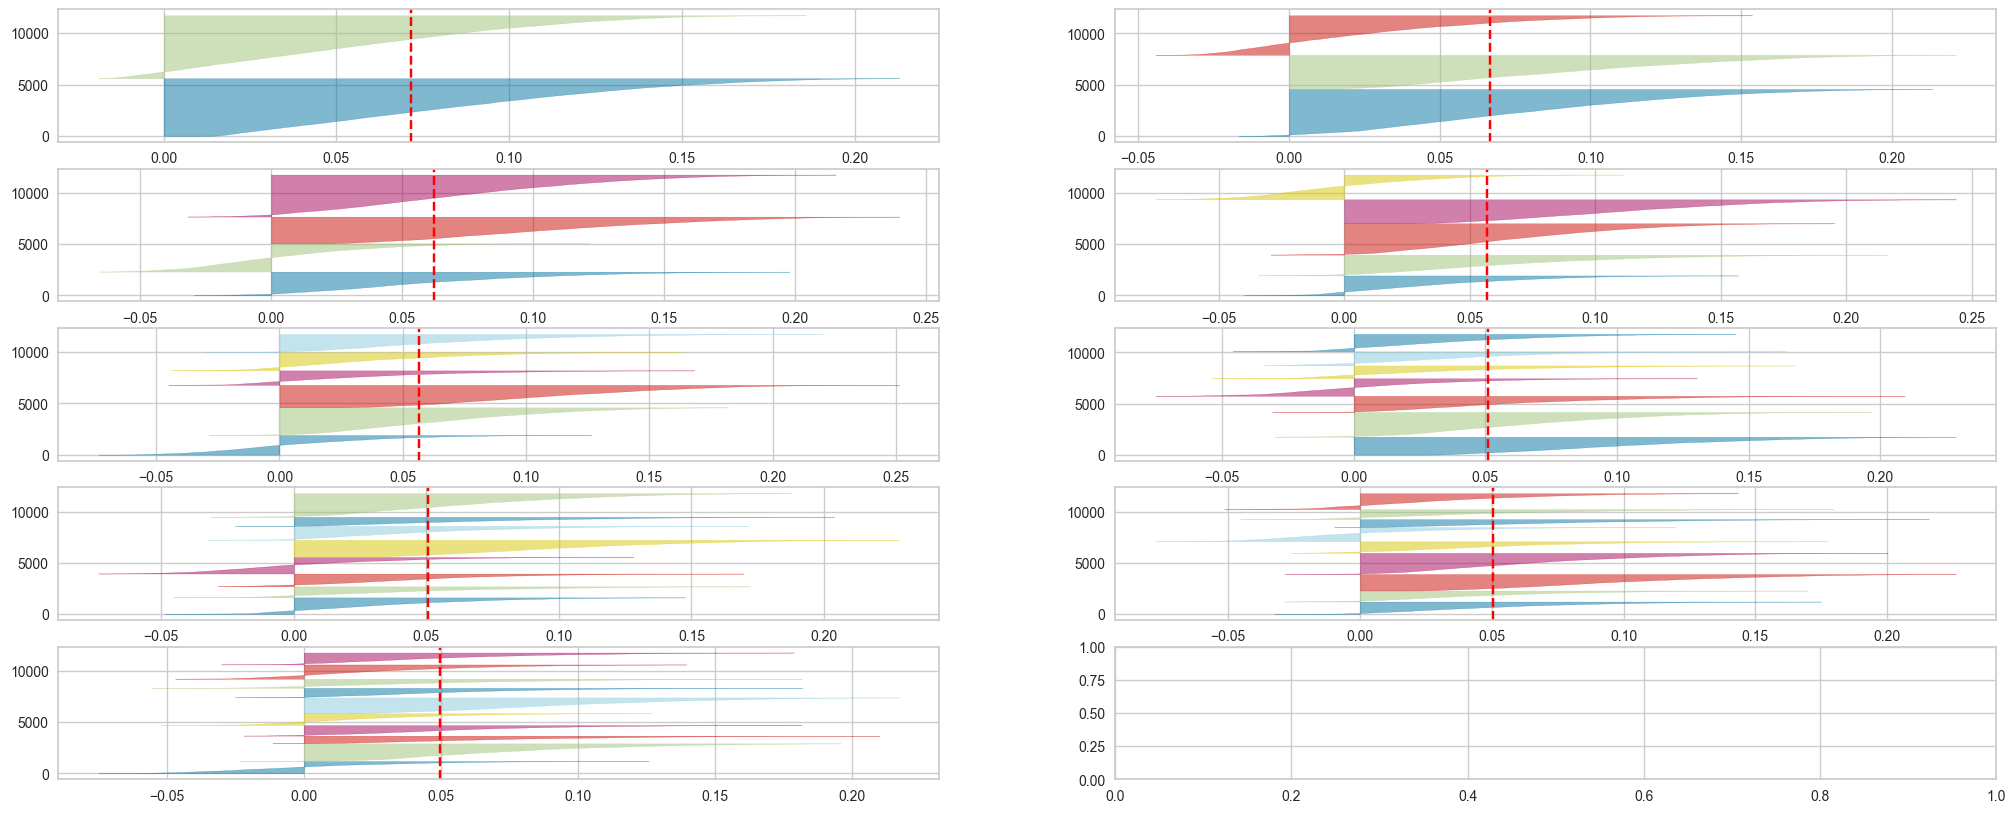

Remember that you should choose cluster size so that the clusters are relatively equal in size


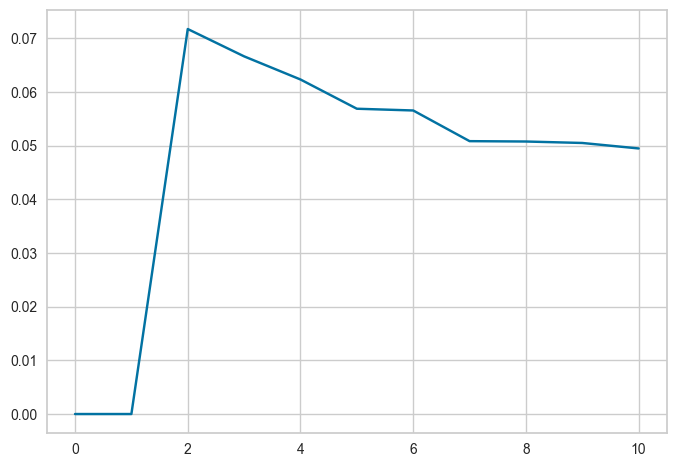

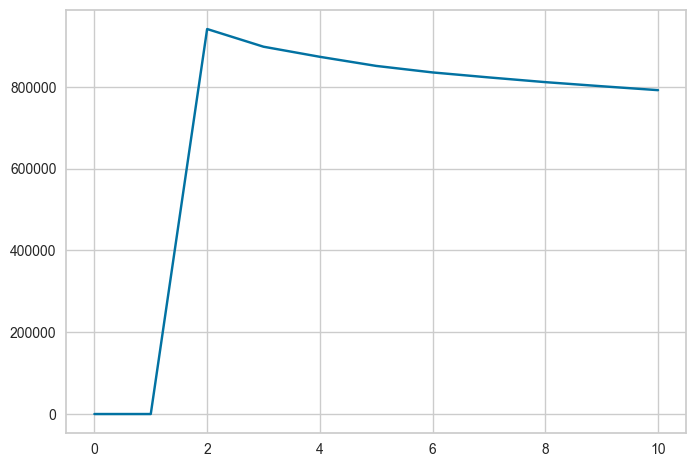

In [113]:
main()


In [ ]:

km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=100, random_state=42).fit(np.load(r'embeddings_clean_context.npy'))


In [ ]:
df = pd.read_csv(r"master.csv")
df['cluster']=km.labels_
df

,index,title,year,wos,en,link,abstract,citations,clean_abstract,abstract_length,cluster
0,0,Financing Climate Change Adaptation: Internati...,2021.0,WOS:000666451800001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Climate change adaptation is one of the main s...,27,one main strategy address global least develop...,64,1
1,1,Driving the agenda for climate change adaptati...,2013.0,WOS:000320956800008,True,"<a href=""https://www.webofscience.com/wos/wosc...",The absence of clear signals from the Norwegia...,55,absence clear signal norwegian state concernin...,62,1
2,2,Climate change adaptation policies and plans: ...,2018.0,WOS:000417078200110,True,"<a href=""https://www.webofscience.com/wos/wosc...",Building a climate-ready adaptation society is...,48,building ready society urgent question cannot ...,167,0
3,3,Place-based climate change adaptation: A criti...,2014.0,WOS:000345061100013,True,"<a href=""https://www.webofscience.com/wos/wosc...",Climate change adaptation frameworks often emp...,66,framework often emphasize tangible community v...,113,0
4,4,Responsibility for private sector adaptation t...,2014.0,WOS:000338711600014,True,"<a href=""https://www.webofscience.com/wos/wosc...",The Intergovernmental Panel on Climate Change ...,56,intergovernmental panel 2007 indicates vulnera...,168,1
...,...,...,...,...,...,...,...,...,...,...,...
11722,11845,Grabbed Urban Landscapes: Socio-spatial Tensio...,2019.0,WOS:000456253500009,True,"<a href=""https://www.webofscience.com/wos/wosc...",Cities confronted with unsustainable developme...,85,city confronted unsustainable development clim...,127,0
11723,11846,Large-scale and local climatic controls on lar...,2020.0,WOS:000506491300001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Rangeland ecosystems worldwide are characteriz...,69,rangeland ecosystem worldwide characterized hi...,262,1
11724,11847,Public Health Measures to Address the Impact o...,2022.0,WOS:000873289500001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Background: The World Health Organization iden...,49,background world health organization identifie...,131,0
11725,11848,A new framework for flood adaptation: introduc...,2022.0,WOS:000877017100001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Traditional flood risk paradigms and associate...,143,traditional flood risk paradigm associated str...,156,0


In [ ]:




df_search = find_article(search)
df_search

In [ ]:
#splitting dataset into clusters
df0 = df[df['cluster'] == 0].reset_index().loc[:,'title':'cluster']
df1 = df[df['cluster'] == 1].reset_index().loc[:,'title':'cluster']
#df2 = df[df['cluster'] == 2].reset_index().loc[:,'title':'cluster']

#df_list = [df0, df1, df2]

In [4]:
topic_model = BERTopic(top_n_words=12,
                        #min_topic_size=50,
                        nr_topics= 10)

In [ ]:
for x in df_list:
    topic, probs = topic_model.fit_transform(x['clean_abstract'])
                                         
dftest = pd.DataFrame()
dftest['Topic'] = topic_model.get_topic_info()['Topic']
dftest['Count'] = topic_model.get_topic_info()['Count']
dftest['Name'] = topic_model.get_topic_info()['Name']
#dftest.to_csv('topics_cluster_'+str(x))

In [ ]:
topic, probs = topic_model.fit_transform(df1['clean_abstract'])
dftest = pd.DataFrame()
dftest['Topic'] = topic_model.get_topic_info()['Topic']
dftest['Count'] = topic_model.get_topic_info()['Count']
dftest['Name'] = topic_model.get_topic_info()['Name']

In [ ]:

topic_model.get_topics()

In [67]:
test = [1,2,3,4,5,6,7,7,7,7,7,5,4,2]

dftest = pd.DataFrame()

dftest['test'] = test

dftest

,test
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,7
8,7
9,7


In [47]:
df = pd.read_csv(r"master.csv")
embeddings = np.load(r'embeddings_clean_context.npy') # choose correct embeddings
range_no_clusters = [2,3,4,5,6,7,8,9,10] # 5, 6, 7, 8, 9, 10, 11]
    # cluster_algorithm = input("choose algorithm: km, ac, or hc")
cluster_algorithm = "km"

df.iat[2489,2] = 2022.0
df['year'] = df['year'].astype(str)
    
nested_list = [arr for arr in embeddings]
#df["embedding"] =  pd.Series(embeddings)
df['embedding'] = [x for x in embeddings]
   # df['embedding'] = df['embedding'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11727 entries, 0 to 11726
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            11727 non-null  int64 
 1   title            11727 non-null  object
 2   year             11727 non-null  object
 3   wos              11727 non-null  object
 4   en               11727 non-null  bool  
 5   link             11727 non-null  object
 6   abstract         11727 non-null  object
 7   citations        11727 non-null  int64 
 8   clean_abstract   11727 non-null  object
 9   abstract_length  11727 non-null  int64 
 10  embedding        11727 non-null  object
dtypes: bool(1), int64(3), object(7)
memory usage: 927.7+ KB


In [72]:
topic, probs = topic_model.fit_transform(df['clean_abstract'],test)
dftest = pd.DataFrame()
dftest['Topic'] = topic_model.get_topic_info()['Topic']
dftest['Count'] = topic_model.get_topic_info()['Count']
dftest['Name'] = topic_model.get_topic_info()['Name']

ValueError: Make sure that the embeddings are a numpy array with shape: (len(docs), vector_dim) where vector_dim is the dimensionality of the vector embeddings. 

NameError: name 'csr_matrix' is not defined

In [76]:
test


<1x1 sparse matrix of type '<class 'numpy.intc'>'
	with 1 stored elements in Compressed Sparse Row format>